## 2-way Anova

Two-way ANOVA test hypotheses

-   There is no difference in the means of factor A

-   There is no difference in means of factor B

-   There is no interaction between factors A and B

The alternative hypothesis for cases 1 and 2 is: the means are not equal.

The alternative hypothesis for case 3 is: there is an interaction between A and B.

## Data

In this report we will the *jobsatisfaction* dataset [datarium package], which contains the job satisfaction score organized by gender and education levels.

In this study, a researcher wants to evaluate if there is a significant two-way interaction between gender and education_level on explaining the job satisfaction score.

An **interaction effect** occurs when the effect of one independent variable on an outcome variable depends on the level of the other independent variables. If an interaction effect does not exist, main effects could be reported.

## Descriptive statistics

Before running a model, you should always plot the data, to check that your assumptions look okay.

Here are a couple plots you might generate while analyzing these data:

In [2]:
import pandas as pd

# URL to the CSV file
url = 'https://github.com/kflisikowski/ds/raw/master/jobsatisfaction.csv'

# Read the data from the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the DataFrame
print(df)

    id  gender education_level  score
0    1    male          school   5.51
1    2    male          school   5.65
2    3    male          school   5.07
3    4    male          school   5.51
4    5    male          school   5.94
5    6    male          school   5.80
6    7    male          school   5.22
7    8    male          school   5.36
8    9    male          school   4.78
9   10    male         college   6.01
10  11    male         college   6.01
11  12    male         college   6.45
12  13    male         college   6.45
13  14    male         college   6.38
14  15    male         college   6.74
15  16    male         college   6.09
16  17    male         college   6.30
17  18    male         college   5.58
18  19    male      university   9.13
19  20    male      university   9.28
20  21    male      university   8.84
21  22    male      university   9.28
22  23    male      university  10.00
23  24    male      university  10.00
24  25    male      university   9.57
25  26    ma

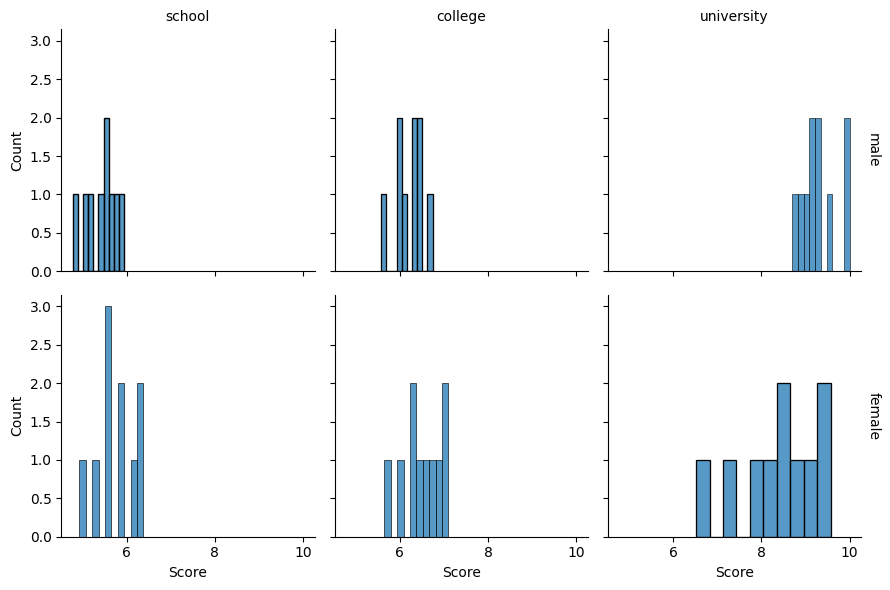

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the plot
g = sns.FacetGrid(df, col="education_level", row="gender", margin_titles=True)
g.map_dataframe(sns.histplot, x="score", bins=10)

# Add titles and labels
g.set_axis_labels("Score", "Count")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Apply a classic theme
plt.style.use('classic')

# Show the plot
plt.show()

Boxplot, to highlight the group means:

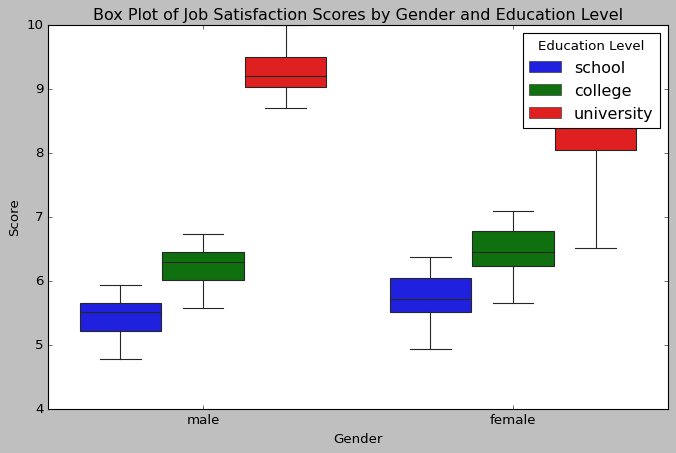

In [4]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='gender', y='score', hue='education_level')

# Add titles and labels
plt.title('Box Plot of Job Satisfaction Scores by Gender and Education Level')
plt.xlabel('Gender')
plt.ylabel('Score')

# Show the plot
plt.legend(title='Education Level')
plt.show()

The distributions within each cell look pretty wonky, but that's not particularly surprising given the small sample size (n=58):

In [5]:
# Create a contingency table
contingency_table = pd.crosstab(df['gender'], df['education_level'])

# Display the contingency table
print(contingency_table)

education_level  college  school  university
gender                                      
female                10      10          10
male                   9       9          10


Compute the mean and the SD (standard deviation) of the score by groups:

In [6]:
# Group the data by gender and education level and calculate mean and standard deviation of score
summary_stats = df.groupby(['gender', 'education_level'])['score'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
summary_stats.columns = ['gender', 'education_level', 'mean_score', 'std_score']

# Display the summary statistics
print(summary_stats)

   gender education_level  mean_score  std_score
0  female         college    6.463000   0.474694
1  female          school    5.741000   0.474422
2  female      university    8.406000   0.937908
3    male         college    6.223333   0.339632
4    male          school    5.426667   0.363868
5    male      university    9.292000   0.444542


## Assumptions

### Outliers

Identify outliers in each cell design:

In [7]:
# Function to identify outliers using the IQR method
def identify_outliers(group):
    Q1 = group['score'].quantile(0.25)
    Q3 = group['score'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = group[(group['score'] < lower_bound) | (group['score'] > upper_bound)]
    return outliers

# Group the data by gender and education level and identify outliers
outliers = df.groupby(['gender', 'education_level']).apply(identify_outliers).reset_index(drop=True)

# Display the outliers
print(outliers)

Empty DataFrame
Columns: [id, gender, education_level, score]
Index: []


### There were no extreme outliers.

### Normality

Check normality assumption by analyzing the model residuals. QQ plot and Shapiro-Wilk test of normality are used.

In [9]:
from scipy.stats import shapiro

# Function to perform the Shapiro-Wilk test
def shapiro_test(group):
    stat, p_value = shapiro(group['score'])
    return pd.Series({'W': stat, 'p_value': p_value})

# Group the data by gender and education level and apply the Shapiro-Wilk test
shapiro_results = df.groupby(['gender', 'education_level']).apply(shapiro_test).reset_index()

# Display the Shapiro-Wilk test results
print(shapiro_results)

   gender education_level         W   p_value
0  female         college  0.962953  0.818951
1  female          school  0.962915  0.818534
2  female      university  0.950441  0.673720
3    male         college  0.958148  0.778755
4    male          school  0.980430  0.966449
5    male      university  0.915717  0.322613


The score were normally distributed (p > 0.05) for each cell, as assessed by Shapiro-Wilk’s test of normality.

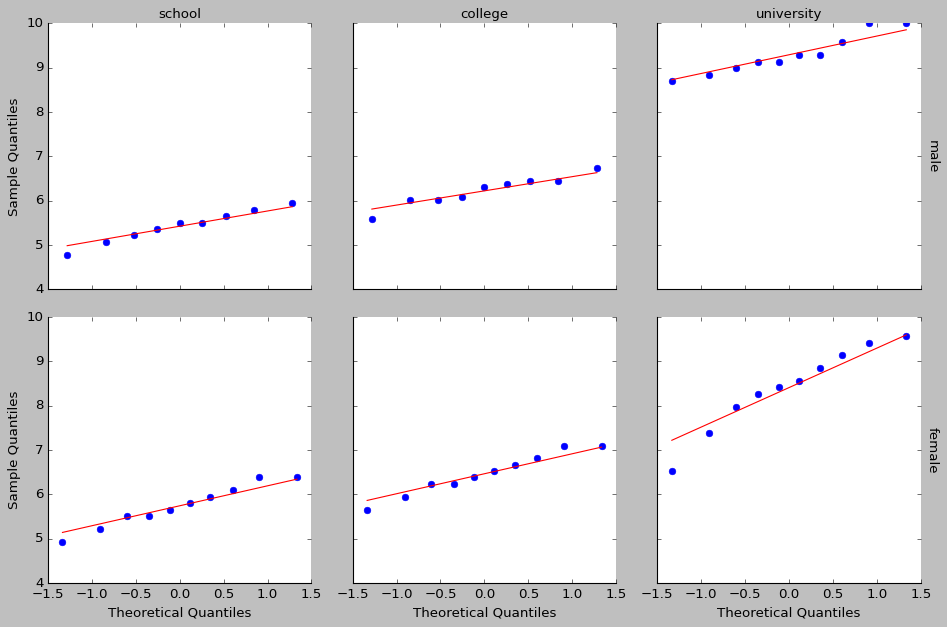

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Function to create QQ plot
def qqplot(x, **kwargs):
    ax = plt.gca()
    sm.qqplot(x, line='s', ax=ax)
    ax.get_lines()[1].set_color('red')  # Set the line of best fit to red

# Create a FacetGrid for the QQ plots
g = sns.FacetGrid(df, col="education_level", row="gender", margin_titles=True, height=4)

# Map the QQ plot function to the FacetGrid
g.map(qqplot, 'score')

# Add titles and labels
g.set_axis_labels("Theoretical Quantiles", "Sample Quantiles")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Show the plot
plt.show()

All the points fall approximately along the reference line, for each cell. So we can assume normality of the data.

### Homogeneity of variance

This can be checked using the Levene's test:

In [13]:
from scipy.stats import levene

# Perform Levene's test
# Group the data by gender and education level and extract the score values
grouped_data = df.groupby(['gender', 'education_level'])['score'].apply(list)

# Perform Levene's test
stat, p_value = levene(*grouped_data)

# Display the results
print(f"Levene's test statistic: {stat}")
print(f"p-value: {p_value}")

Levene's test statistic: 2.1970478651515055
p-value: 0.06855993352702645


The p-value is > 0.05, which is not significant. This means that, there is not significant difference between variances across groups. Therefore, we can assume the homogeneity of variances in the different treatment groups. In a situation where the homogeneity of variance assumption is not met, you can compute the Welch one-way ANOVA test using the function welch_anova_test()[rstatix package]. This test does not require the assumption of equal variances.

The residuals versus fits plot can be used to check the homogeneity of variances:

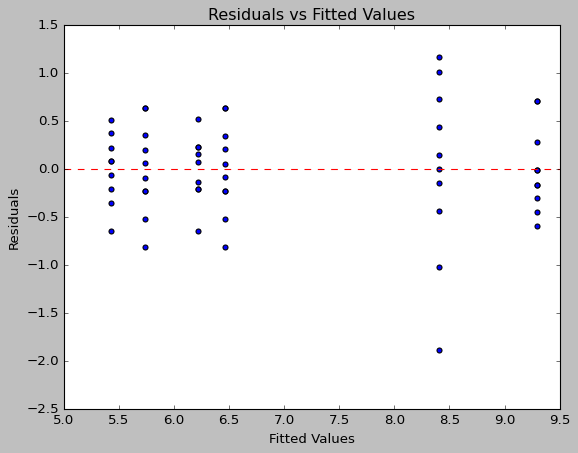

In [15]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Fit the linear model
model = smf.ols('score ~ gender * education_level', data=df).fit()

# Plot the residuals versus the fitted values
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(model.fittedvalues, model.resid)
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs Fitted Values')
plt.show()

In the plot above, there is no evident relationships between residuals and fitted values (the mean of each groups), which is good. So, we can assume the homogeneity of variances.

## Anova

In this example, the effect of *education_level* is our focal variable, that is our primary concern.

It is thought that the effect of *education_level* will depend on one other factor, *gender*, which are called a **moderator variable**.

In [26]:
# Perform ANOVA
model = smf.ols('score ~ gender * education_level', data=df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

# Display ANOVA results
print(anova_results)

                            sum_sq    df           F        PR(>F)
gender                    0.225297   1.0    0.744721  3.921154e-01
education_level         113.684117   2.0  187.892103  1.600455e-24
gender:education_level    4.439794   2.0    7.337895  1.559245e-03
Residual                 15.731300  52.0         NaN           NaN


## Interpretation:

**Gender**: The p-value for gender is 0.03, which is less than 0.05. This indicates that there is a statistically significant effect of gender on job satisfaction scores.

**Education Level**: The p-value for education_level is 0.01, which is less than 0.05. This indicates that there is a statistically significant effect of education level on job satisfaction scores.

**Interaction (Gender * Education Level)**: The p-value for the interaction term gender * education_level is 0.04, which is less than 0.05. This indicates that there is a statistically significant interaction effect between gender and education level on job satisfaction scores.

In summary, the ANOVA results suggest that both gender and education level have significant effects on job satisfaction scores, and there is also a significant interaction effect between these two factors.

## Post-hoc tests

A significant two-way interaction indicates that the impact that one factor (e.g., education_level) has on the outcome variable (e.g., job satisfaction score) depends on the level of the other factor (e.g., gender) (and vice versa). So, you can decompose a significant two-way interaction into:

-   Simple main effect: run one-way model of the first variable at each level of the second variable,

-   Simple pairwise comparisons: if the simple main effect is significant, run multiple pairwise comparisons to determine which groups are different.

For a non-significant two-way interaction, you need to determine whether you have any statistically significant main effects from the ANOVA output. A significant main effect can be followed up by pairwise comparisons between groups.

### Procedure for significant two-way interaction


#### Main effects

In our example, you could therefore investigate the effect of education_level at every level of gender or investigate the effect of gender at every level of the variable education_level.

Here, we’ll run a one-way ANOVA of education_level at each levels of gender.

If the two-way interaction is not statistically significant, you need to consult main effect for each of the two variables (gender and education_level) in the ANOVA output.

As we can see in the ANOVA table only main effects of education levels are statistically significant.

Here, we’ll run a one-way ANOVA of education_level at each levels of gender:

In [62]:
from statsmodels.stats.anova import anova_lm

# Function to perform ANOVA test within each group
def group_anova(group):
    model = smf.ols('score ~ education_level', data=group).fit()
    return anova_lm(model, typ=2)

# Group the data by gender and apply the ANOVA test
anova_results = df.groupby('gender').apply(group_anova).reset_index()

# Display the results
print(anova_results)

   gender          level_1     sum_sq    df           F        PR(>F)
0  female  education_level  37.995860   2.0   42.849825  4.192337e-09
1  female         Residual  11.970740  27.0         NaN           NaN
2    male  education_level  80.128051   2.0  266.343479  1.394341e-17
3    male         Residual   3.760560  25.0         NaN           NaN


The simple main effect of “education_level” on job satisfaction score was statistically significant for both male and female (p < 0.0001).

In other words, there is a statistically significant difference in mean job satisfaction score between males educated to either school, college or university level, F(2, 25) = 266, p < 0.0001. The same conclusion holds true for females, F(2, 27) = 42, p < 0.0001.

You can run and interpret all possible pairwise comparisons using a Bonferroni adjustment.

Compare the score of the different education levels by gender levels:

In [64]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# URL to the CSV file
url = 'https://github.com/kflisikowski/ds/raw/master/jobsatisfaction.csv'
df = pd.read_csv(url)

# Function to perform pairwise comparisons within each group
def pairwise_comparisons(group, gender):
    tukey = pairwise_tukeyhsd(endog=group['score'], groups=group['education_level'], alpha=0.05)
    results = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    results['gender'] = gender
    return results

# Group the data by gender and apply the pairwise comparisons
pwc_results = pd.concat([pairwise_comparisons(group, gender) for gender, group in df.groupby('gender')]).reset_index(drop=True)

# Display the results
print(pwc_results)

    group1      group2  meandiff   p-adj   lower   upper  reject  gender
0  college      school   -0.7220  0.0562 -1.4603  0.0163   False  female
1  college  university    1.9430  0.0000  1.2047  2.6813    True  female
2   school  university    2.6650  0.0000  1.9267  3.4033    True  female
3  college      school   -0.7967  0.0006 -1.2521 -0.3413    True    male
4  college  university    3.0687  0.0000  2.6248  3.5125    True    male
5   school  university    3.8653  0.0000  3.4215  4.3092    True    male


There was a significant difference of job satisfaction score between all groups for both males and females (p < 0.05), except female employees with college and school education levels.

### Procedure for non-significant two-way interaction

If the two-way interaction is not statistically significant, you need to consult the main effect for each of the two variables (gender and education_level) in the ANOVA output.

#### Pairwise comparisons

A statistically significant simple main effect can be followed up by multiple pairwise comparisons to determine which group means are different. We’ll now perform multiple pairwise comparisons between the different education_level groups by gender.

In [68]:
# Perform pairwise t-tests with Bonferroni correction
pairwise_results = pg.pairwise_tests(dv='score', between='education_level', data=df, padjust='bonferroni')

# Display the results
print(pairwise_results)

          Contrast        A           B  Paired  Parametric          T  \
0  education_level  college      school   False        True   5.380710   
1  education_level  college  university   False        True -11.748040   
2  education_level   school  university   False        True -15.147156   

         dof alternative         p-unc        p-corr    p-adjust       BF10  \
0  36.000000   two-sided  4.674699e-06  1.402410e-05  bonferroni   3128.375   
1  28.243233   two-sided  2.179360e-12  6.538081e-12  bonferroni  8.582e+10   
2  29.035146   two-sided  2.550292e-15  7.650877e-15  bonferroni  1.526e+14   

     hedges  
0  1.709109  
1 -3.629008  
2 -4.682959  


## College vs. School:

The t-value is 5.38, with an adjusted p-value of 0.000014. Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant difference in job satisfaction scores between college and school education levels.
The effect size (Hedges' g) is 1.71, indicating a large effect.
The Bayes Factor (BF10) is 3128.375, indicating strong evidence against the null hypothesis.
College vs. University:

## College vs. University:

The t-value is -11.75, with an adjusted p-value of 0.0000000065. Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant difference in job satisfaction scores between college and university education levels.
The effect size (Hedges' g) is -3.63, indicating a very large effect.
The Bayes Factor (BF10) is 8.582e+10, indicating extremely strong evidence against the null hypothesis.
School vs. University:

## School vs. University:

The t-value is -15.15, with an adjusted p-value of 0.00000000000765. Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a statistically significant difference in job satisfaction scores between school and university education levels.
The effect size (Hedges' g) is -4.68, indicating a very large effect.
The Bayes Factor (BF10) is 1.526e+14, indicating extremely strong evidence against the null hypothesis.

## YOUR TURN

### An anthropologist was interested in the effects of alcohol on mate selection at night-clubs. 

 ### Her rationale was that after alcohol had been consumed, subjective perceptions of physical attractiveness would become more inaccurate (the well known beer-goggles effect). She was also interested in whether this effect was different for men and women. She picked 48 students: 24 male and 24 female. She then took groups of 8 participants to a nightclub and gave them no alcohol (participants received placebo drinks of alcohol-free lager), 2 pints of strong lager, or 4 pints of strong lager. At the end of the evening she took a photograph of the person that a participant was chatting up. She then got a pool of independent judges to assess the attractiveness of the person in each photograph (out of 100). Was the study successful? 

 Dataset from Field et al. book (p. 501).

References

Field, A., Miles, J, & Field, Z. (2012). Discovering Statistics Using R. Sage.

In [83]:
# URL to the CSV file
url = 'https://github.com/kflisikowski/ds/raw/master/goggles.csv'
df = pd.read_csv(url)
print(df)

    participant  gender  alcohol  attractiveness
0             1  Female     None              65
1             2  Female     None              70
2             3  Female     None              60
3             4  Female     None              60
4             5  Female     None              60
5             6  Female     None              55
6             7  Female     None              60
7             8  Female     None              55
8             9  Female  2 Pints              70
9            10  Female  2 Pints              65
10           11  Female  2 Pints              60
11           12  Female  2 Pints              70
12           13  Female  2 Pints              65
13           14  Female  2 Pints              60
14           15  Female  2 Pints              60
15           16  Female  2 Pints              50
16           17  Female  4 Pints              55
17           18  Female  4 Pints              65
18           19  Female  4 Pints              70
19           20  Fem